<a href="https://colab.research.google.com/github/romenlaw/ML-playground/blob/main/ml_playground2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [72]:
import random
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
import pandas as pd
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split

TOTAL_FRAMES=50
random.seed(20)

# Some functions to plot our points and draw the lines
def plot_points(features, labels, ax=None):
  X = np.array(features)
  y = np.array(labels)
  spam = X[np.argwhere(y==1)]
  ham = X[np.argwhere(y==0)]
  if ax is None:
    p=plt
    p.xlabel('ha')
    p.ylabel('boo')
  else:
    p=ax
    p.set_xlabel('ha')
    p.set_ylabel('boo')
  p.scatter([s[0][0] for s in spam],
            [s[0][1] for s in spam],
            s = 100,
            color = 'cyan',
            edgecolor = 'k',
            marker = '^')
  p.scatter([s[0][0] for s in ham],
            [s[0][1] for s in ham],
            s = 100,
            color = 'red',
            edgecolor = 'k',
            marker = 's')
  p.legend(['happy','sad'])

def draw_line(a,b,c, starting=0, ending=3, **kwargs):
  # Plotting the line ax + by + c = 0
  x = np.linspace(starting, ending, 1000)
  plt.plot(x, -c/b - a*x/b, **kwargs)

# Classification

Regression models predict a number; whereas *classification* models predict a state or a category (drawing a line to separate our data points).

*Perceptron* uses linear regression and is building block of neuro net.

Instead of expressing a line with $y=mx+b$, we rewrite it into $w_1x_1+w_2x_2+b=0$
The line divides the plane into two zones with LHS>=0 being the positive zone, LHS<0 the negative zone.

If we want to flip the positive and negative zones, simplly change the sign of all the w and b in the equation.

Step function (a specific case of activation function):
* $step(x)=1 \text{ if } x\ge 0 $
* $step(x)=0 \text{ if } x\lt 0 $

The perceptron can be expressed with step function - the perceptron produces 1 if point is in positive zone; 0 if in negative zone:
$$\hat{y}=step(w_1x_1+w_2x_2+b)$$

The bias / intercept term basically gives the result for when w's are 0. i.e. in the alien sentiment example, it's the sentiment of a quiet alien (no words are said).

## Error function

Intuitively, we can sum up the distance of wrongly classified points and the dividing line. But this is not used because it's complicated to calculate the distance: the square root has complicated derivative.

So instead we use a *score* with these properties:
1. points on boundary, score=0
2. points in +zone, score>0
3. points in -zone, score<0
4. points close to boundary, |score| is small
5. points far from boundary, |score| is large

The *perceptron error* should be proportional to the distance between point and boundary. The perceptron for a point is defined as:
1. if point is correctly classified, error=0
2. if point is misclassified, $\text{error}=|w_1x_1+w_2x_2+\ldots+w_nx_n+b|=| w\cdotp x + b |=|\text{score}|$

The derivitives of the error:
* $\frac{\delta \text{error}}{\delta w}=x$
* $\frac{\delta \text{error}}{\delta b}=1$

The *mean perceptron error* (i.e. the error for entire dataset) = average of perceptron errors of all points.

## Perceptron Algorithm

Using the happy/sad alien as an example. They have two words (Ha, Boo) in their vocab (i.e. features is 2-dim).

   Ha  Boo  Happy(1)/Sad(0)
0   1    0                0
1   0    2                0
2   1    1                0
3   1    2                0
4   1    3                1
5   2    2                1
6   2    3                1
7   3    2                1


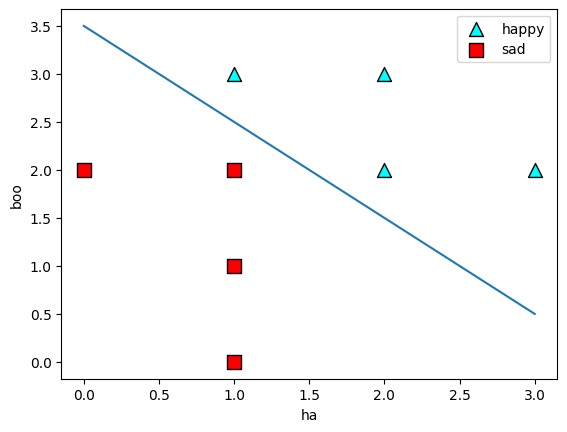

In [73]:
# we have 8 data points and their labels in the dataset
batch_features = np.array([[1,0],[0,2],[1,1],[1,2],[1,3],[2,2],[2,3],[3,2]])
labels = np.array([0,0,0,0,1,1,1,1])

# printing the dataset in table
df = pd.DataFrame({
    'Ha' : batch_features[:,0],
    'Boo' : batch_features[:,1],
    'Happy(1)/Sad(0)': labels
})
print(df)

# Plotting the points
plot_points(batch_features, labels)

# Uncomment the following line to see a good line fit for this data.
draw_line(1,1,-3.5)

In [132]:
#############
# m=batch size, n=vocab dim (num of words)
# weights: dim (n,)
# bias: scalar
# features: (n,)
# label: scalar
# batch_features: (m, n)
# labels: (m)
#############
def step(x):
  return 1 if x>=0 else 0

def score(weights, bias, features):
  return np.dot(features, weights) + bias

def prediction(weights, bias, features):
  return step(score(weights, bias, features))

def error(weights, bias, features, label):
  pred = prediction(weights, bias, features)
  if pred == label:
    return 0
  else:
    return np.abs(score(weights, bias, features))

def mean_perceptron_error(weights, bias, batch_features, labels):
  total_error = 0
  batch_size = len(batch_features) # number of points in the dataset
  for i in range(batch_size):
    total_error += error(weights, bias, batch_features[i], labels[i])

  return total_error / batch_size

# the back prop
def perceptron_trick(weights, bias, features, label, learning_rate = 0.01):
  pred = prediction(weights, bias, features)
  delta = (label-pred) * learning_rate
  n = len(weights)
  for i in range(n):
    weights[i] += delta * features[i]
  bias += delta
  return weights, bias

def perceptron_algorithm(batch_features, labels, learning_rate = 0.01, epochs=200):
  m = len(batch_features)
  n = len(batch_features[0])
  weights = [random.random() for i in range(n)]
  bias = random.random()
  Ws, bs, errs = [None] * epochs, [None] * epochs, [None] * epochs

  for epoch in range(epochs):
    error = mean_perceptron_error(weights, bias, batch_features, labels)

    i = random.randint(0, m-1) # Pick a random point in our dataset
    weights, bias = perceptron_trick(weights, bias, batch_features[i], labels[i])

    # preceptron_trick updates elements of weights list, so it's returning the
    # original list, so here we need to make a copy
    Ws[epoch] = weights.copy()
    bs[epoch] = bias
    errs[epoch]=error

    # print(f"o w={weights}, b={bias}")
    # print(f"x w={Ws[epoch]}, b={bs[epoch]}")

  return Ws, bs, errs

weights=[0.029923152866939858, 0.02595615591041223], bias=-0.10025481851754135
errors: max=1.01106637051034, min=0.0


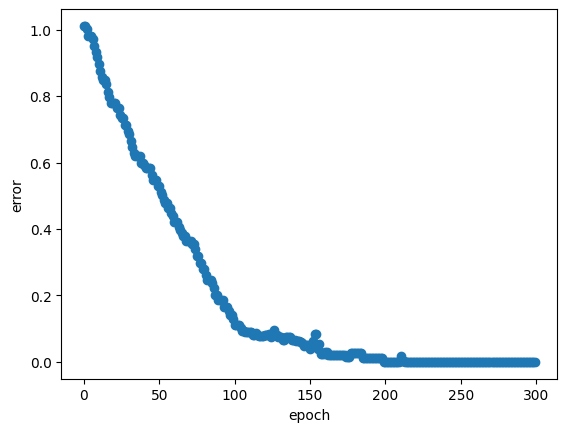

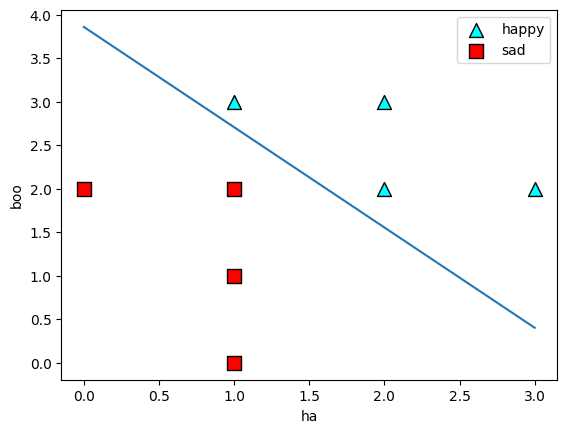

In [136]:
epochs=300
Ws, bs, errs = perceptron_algorithm(batch_features, labels, learning_rate=0.01, epochs=epochs)
w = Ws[-1]
b = bs[-1]

print(f"weights={w}, bias={b}")
print(f"errors: max={max(errs)}, min={min(errs)}")

plt.scatter(np.arange(epochs), errs)
plt.xlabel('epoch')
plt.ylabel('error')
plt.show()

plot_points(batch_features, labels)
# Uncomment the following line to see a good line fit for this data.
draw_line(w[0],w[1],b)

In [137]:
frames = np.linspace(0, epochs, TOTAL_FRAMES, dtype=np.uint32)
frames, len(frames)

(array([  0,   6,  12,  18,  24,  30,  36,  42,  48,  55,  61,  67,  73,
         79,  85,  91,  97, 104, 110, 116, 122, 128, 134, 140, 146, 153,
        159, 165, 171, 177, 183, 189, 195, 202, 208, 214, 220, 226, 232,
        238, 244, 251, 257, 263, 269, 275, 281, 287, 293, 300],
       dtype=uint32),
 50)

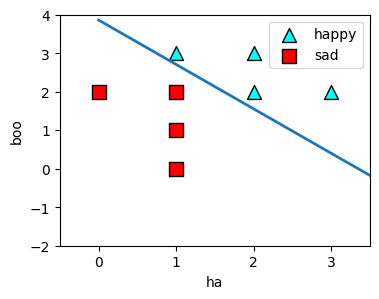

In [138]:
# check the progress of the training
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

fig, ax = plt.subplots(figsize=(4,3))
ax.set_xlim(-0.5, 3.5)
ax.set_ylim(-2, 4)
plot_points(batch_features, labels, ax=ax)
line, = ax.plot([], [], lw=2)

def init():
  line.set_data([], [])
  return line,

def update(frame):
  idx = min(epochs-1, frames[frame])
  W = Ws[idx]
  b = bs[idx]
  w1, w2 = W[0], W[1]
  x = np.linspace(0, 10, 1000)
  y = -b/w2 - w1*x/w2
  line.set_data(x, y)
  return line,

ani = FuncAnimation(fig, update, frames=TOTAL_FRAMES, init_func=init, blit=True)
HTML(ani.to_jshtml())